In [8]:
import numpy as np
import os
import json
from glob import glob
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import utils.workspace as ws
from generator.generator import Generator
%matplotlib qt

In [2]:
# path_traj = "./data/trajectories_interpolated"
path_img = "../2dDeepSDF/data/random_obstacle/BW"
# filenames_traj = sorted(glob(os.path.join(path_traj, "*.json")))
# trajectories_dict_all = [json.load(open(f)) for f in filenames_traj]
filenames_img = sorted(glob(os.path.join(path_img, "*.jpg")))
imgs = [plt.imread(f) for f in filenames_img]

# I/O paths
# env_data_folder = specs["eval"]["EnvDataFolder"]
env_data_folder = "../2dDeepSDF/chomp256/Reconstructions/Codes"
filenames_env = sorted(glob(os.path.join(env_data_folder, '*.npy')))
envs = [np.load(f) for f in filenames_env ]

print("Found {} images".format(len(filenames_img)))
print("Found {} Latent codes".format(len(filenames_env)))

Found 1000 images
Found 1000 Latent codes


In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

experiment_directory = "generator"
checkpoint = str(200)
specs = ws.load_experiment_specifications(experiment_directory)

# Instantiating the model
input_dim = specs["InputDim"]
output_dim = specs["OutputDim"]
hid_dim = specs["HiddenDim"]
n_layers = specs["NLayers"]
dropout = specs["Dropout"]
model = Generator(input_dim, output_dim, hid_dim,
                  n_layers).to(device)

path_to_model_dir = os.path.join(experiment_directory, ws.model_params_dir)
print("Loading checkpoint {} model from: {}".format(
    checkpoint, os.path.abspath(path_to_model_dir)))
model.load_model_parameters(path_to_model_dir, checkpoint)

print('############# Generator Model: #####################')
print(model)
print('######################################################')
model.to(device)
model.eval()

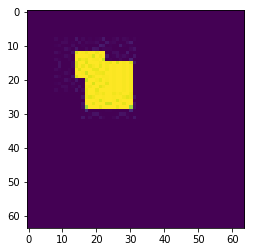

In [4]:
plt.imshow(imgs[0])

In [15]:
def generate(start, goal, img_nb, envs=envs, imgs=imgs):
    start = np.array(start) / 63
    goal = np.array(goal) / 63
    img = imgs[img_nb]
    env = torch.from_numpy(envs[img_nb]).to(device)
    trajectory_points = []
    inputs = torch.from_numpy(np.array([start])).to(device).float()
    seq_length = specs["SeqLength"]
    h = model.init_hidden(1)
    with torch.no_grad():
        for timestep in range(seq_length-2):
            inputs = torch.cat([env, inputs], dim=-1).unsqueeze(1)
            inputs, h = model(inputs, h)
            trajectory_points.append(inputs.squeeze().cpu().numpy())
    
    # prepending and appending respectively start and goal
    trajectory_points = np.array(trajectory_points)

    
    trajectory = np.vstack(
        [start.reshape(1,2), trajectory_points, goal.reshape(1, 2)])
    trajectory = trajectory * 63
    print(trajectory)
    
    
    x = trajectory[:,0]
    y = trajectory[:,1]
    
    
    plt.plot(x, y, "-o")
    plt.gca().invert_yaxis()
    plt.imshow(img)
#     plt.show()
    plt.title("Generated trajectory")


In [19]:
start, goal = [34,40], [10, 40]
img_nb = 0
generate(start, goal, 2)

[[34.         40.        ]
 [33.41898751 34.81810123]
 [36.01375651 36.25130743]
 [38.59944195 37.37319767]
 [40.96643454 38.22950149]
 [42.93505687 38.74734378]
 [44.42224628 38.88547111]
 [45.42789388 38.7080242 ]
 [46.02478838 38.34319818]
 [46.32521832 37.91711533]
 [46.43363535 37.51672107]
 [46.4244504  37.18244272]
 [46.34472227 36.92060387]
 [46.22423261 36.72130609]
 [46.08262807 36.57078695]
 [45.93316787 36.45683116]
 [45.78471029 36.37006223]
 [45.64301562 36.30364591]
 [45.51157612 36.25267428]
 [45.39230686 36.21357626]
 [45.28600395 36.18368196]
 [45.19267112 36.16098994]
 [45.11182022 36.14393806]
 [45.0426026  36.13130218]
 [44.98398936 36.12211722]
 [44.93486148 36.11560214]
 [44.89408118 36.11114109]
 [44.86054444 36.10824215]
 [44.83322614 36.10649604]
 [44.81116498 36.10560608]
 [44.79352355 36.10532069]
 [44.77955085 36.10545212]
 [44.76859349 36.10586518]
 [44.76009947 36.10643971]
 [44.75358438 36.10710061]
 [44.7486577  36.1077953 ]
 [44.74498522 36.10848248]
 